In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)

import dis2p.dis2pvae as dvae
import dis2p.dis2pvi as dvi

[2023-11-10 10:26:11,384] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Global seed set to 0
Global seed set to 0


In [2]:
# load dataset
adata = sc.read('/lustre/scratch126/cellgen/team205/ml19/Norman2019_normalized_hvg.h5ad')
adata

AnnData object with n_obs × n_vars = 111122 × 5044
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'n_counts', 'condition', 'pert_type', 'cell_type', 'source', 'condition_ID', 'control', 'dose_value', 'pathway', 'cov_cond', 'pert', 'split_hardest', 'split_1', 'split_2', 'split_3', 'split_4', 'split_5', 'split_6', 'cond_harm'
    var: 'ensemble_id', 'ncounts', 'ncells', 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'gene_embedding_path', 'hvg', 'log1p', 'neighbors', 'rank_genes_groups_cov', 'source_colors', 'split_1_colors', 'split_2_colors', 'split_3_colors', 'split_4_colors', 'split_5_colors', 'split_hardest_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'd

In [3]:
gene2vec = sc.read('/lustre/scratch126/cellgen/team205/ml19/gene2vec_embeddings.h5ad')
gene2vec

AnnData object with n_obs × n_vars = 24447 × 200
    obs: 'gene_name'

In [4]:
# specify name of dataset 
data_name = 'Norman'

# specify attributes
cats = ['condition']

# create numerical index for each attr in cats
for i in range(len(cats)):
    values = list(set(adata.obs[cats[i]]))
    val_to_idx = {v: values.index(v) for v in values}
    idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]
    adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

In [5]:
gene_emb_dict = {}
genes = list(gene2vec.obs['gene_name'].unique())
for gene in adata.obs['condition'].unique():
    try:
        gene_emb_dict[gene] = gene2vec.X[genes.index(gene),:]
    except ValueError:
        try:
            if '+' in gene:
                splitted = gene.split('+')
                gene_emb_dict[gene] = (gene2vec.X[genes.index(splitted[0]), :] + gene2vec.X[genes.index(splitted[1]),:])
            else:
                print(gene)
        except:
            print(gene)
            continue

ctrl


In [6]:
pert_idx_map = {}
for idx in adata.obs.index:
    pert_idx_map[adata.obs.loc[idx, 'condition']] = adata.obs.loc[idx, 'condition_idx']

In [7]:
gene_emb_dict = {pert_idx_map[key]: value for key, value in gene_emb_dict.items()}

In [8]:
embedding = torch.zeros(235, 200)
for key, value in gene_emb_dict.items():
    embedding[key, :] = torch.Tensor(value)

In [9]:
gb = adata.obs.groupby(['condition'])['condition_ID'].value_counts()
cond_dict = {}
for cond, condID in gb[gb.values!=0].index:
    cond_dict[cond] = condID

In [10]:
# train params
epochs = 40
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 500
adv_clf_weight = 100
adv_period = 3
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

dvi.Dis2pVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
model = dvi.Dis2pVI(adata, n_layers=n_layers, split_key='split_1', use_custom_embs=True, embeddings=embedding)
model.train(**train_dict)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/2/0]
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:331: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 40/40: 100%|██████████| 40/40 [42:06<00:00, 63.33s/it, v_num=1, loss_validation=6.38e+3, x_0_validation=1.24e+3, x_1_validation=1.26e+3, rec_x_cf_validation=1.32e+3, z_1_validation=22.8, ce_validation=5.12, acc_validation=0.346, f1_validation=0.346, adv_ce_validation=5.33, adv_acc_validation=0.134, adv_f1_validation=0.134, loss_train=5.9e+3, x_0_train=1.24e+3, x_1_train=1.26e+3, rec_x_cf_train=1.32e+3, z_1_train=25, ce_train=5.11, acc_train=0.353, f1_train=0.353, adv_ce_train=4.81, adv_acc_train=0.138, adv_f1_train=0.138]     

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [42:06<00:00, 63.17s/it, v_num=1, loss_validation=6.38e+3, x_0_validation=1.24e+3, x_1_validation=1.26e+3, rec_x_cf_validation=1.32e+3, z_1_validation=22.8, ce_validation=5.12, acc_validation=0.346, f1_validation=0.346, adv_ce_validation=5.33, adv_acc_validation=0.134, adv_f1_validation=0.134, loss_train=5.9e+3, x_0_train=1.24e+3, x_1_train=1.26e+3, rec_x_cf_train=1.32e+3, z_1_train=25, ce_train=5.11, acc_train=0.353, f1_train=0.353, adv_ce_train=4.81, adv_acc_train=0.138, adv_f1_train=0.138]


In [11]:
adata.obs['split_1'].value_counts()

split_1
train    68915
ood      24917
valid    17290
Name: count, dtype: int64

In [12]:
module_name = 'scDiffair'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

model.save(f"{pre_path}/{model_name}")

In [20]:
# load model
pre_path = f'models/scDiffair'
model_name = f'{today},scDiffair,Norman,n_layers=1,max_epochs=40,batch_size=128,cf_weight=1,beta=1,clf_weight=500,adv_clf_weight=100,adv_period=3,n_cf=1'
model = dvi.Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)
print('model loaded')
# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)
print('Z_0 latent done')
for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

INFO     File                                                                                                      
         models/scDiffair/2023-11-10,scDiffair,Norman,n_layers=1,max_epochs=40,batch_size=128,cf_weight=1,beta=1,cl
         f_weight=500,adv_clf_weight=100,adv_period=3,n_cf=1/model.pt already downloaded                           
model loaded
Z_0 latent done


---UMAP for dis2p_Z_0---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


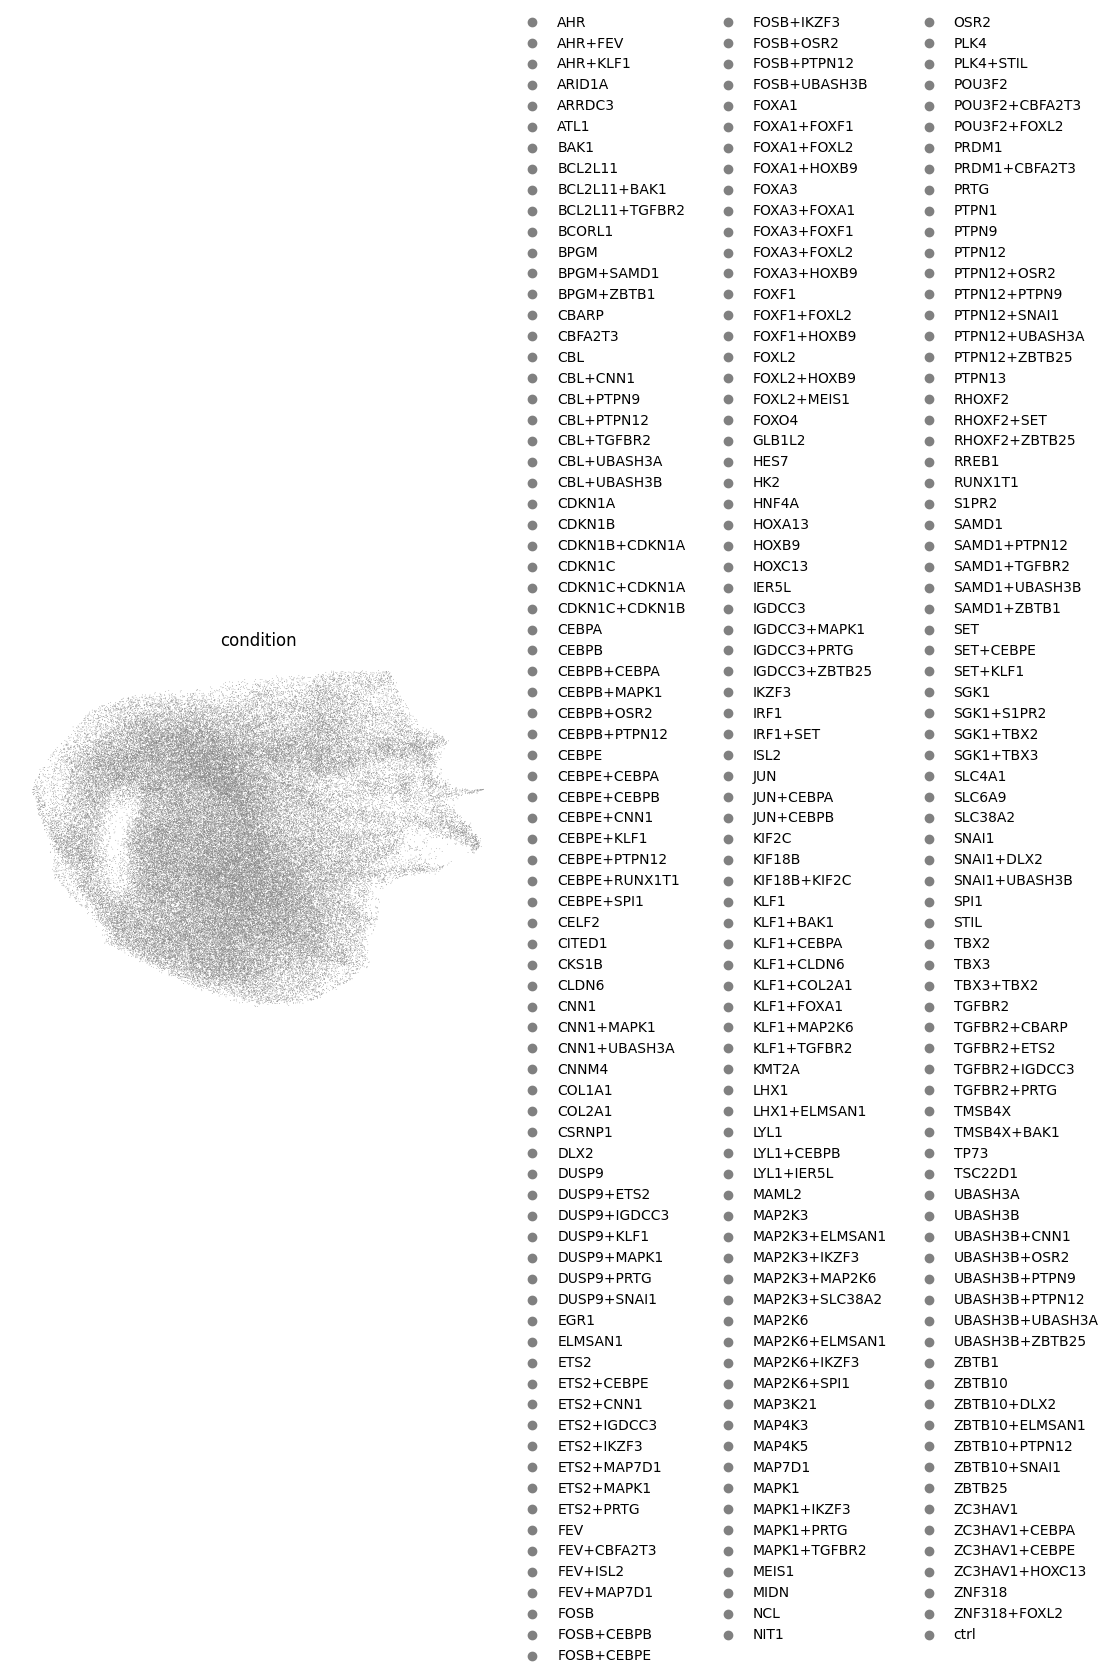

---UMAP for dis2p_Z_1---


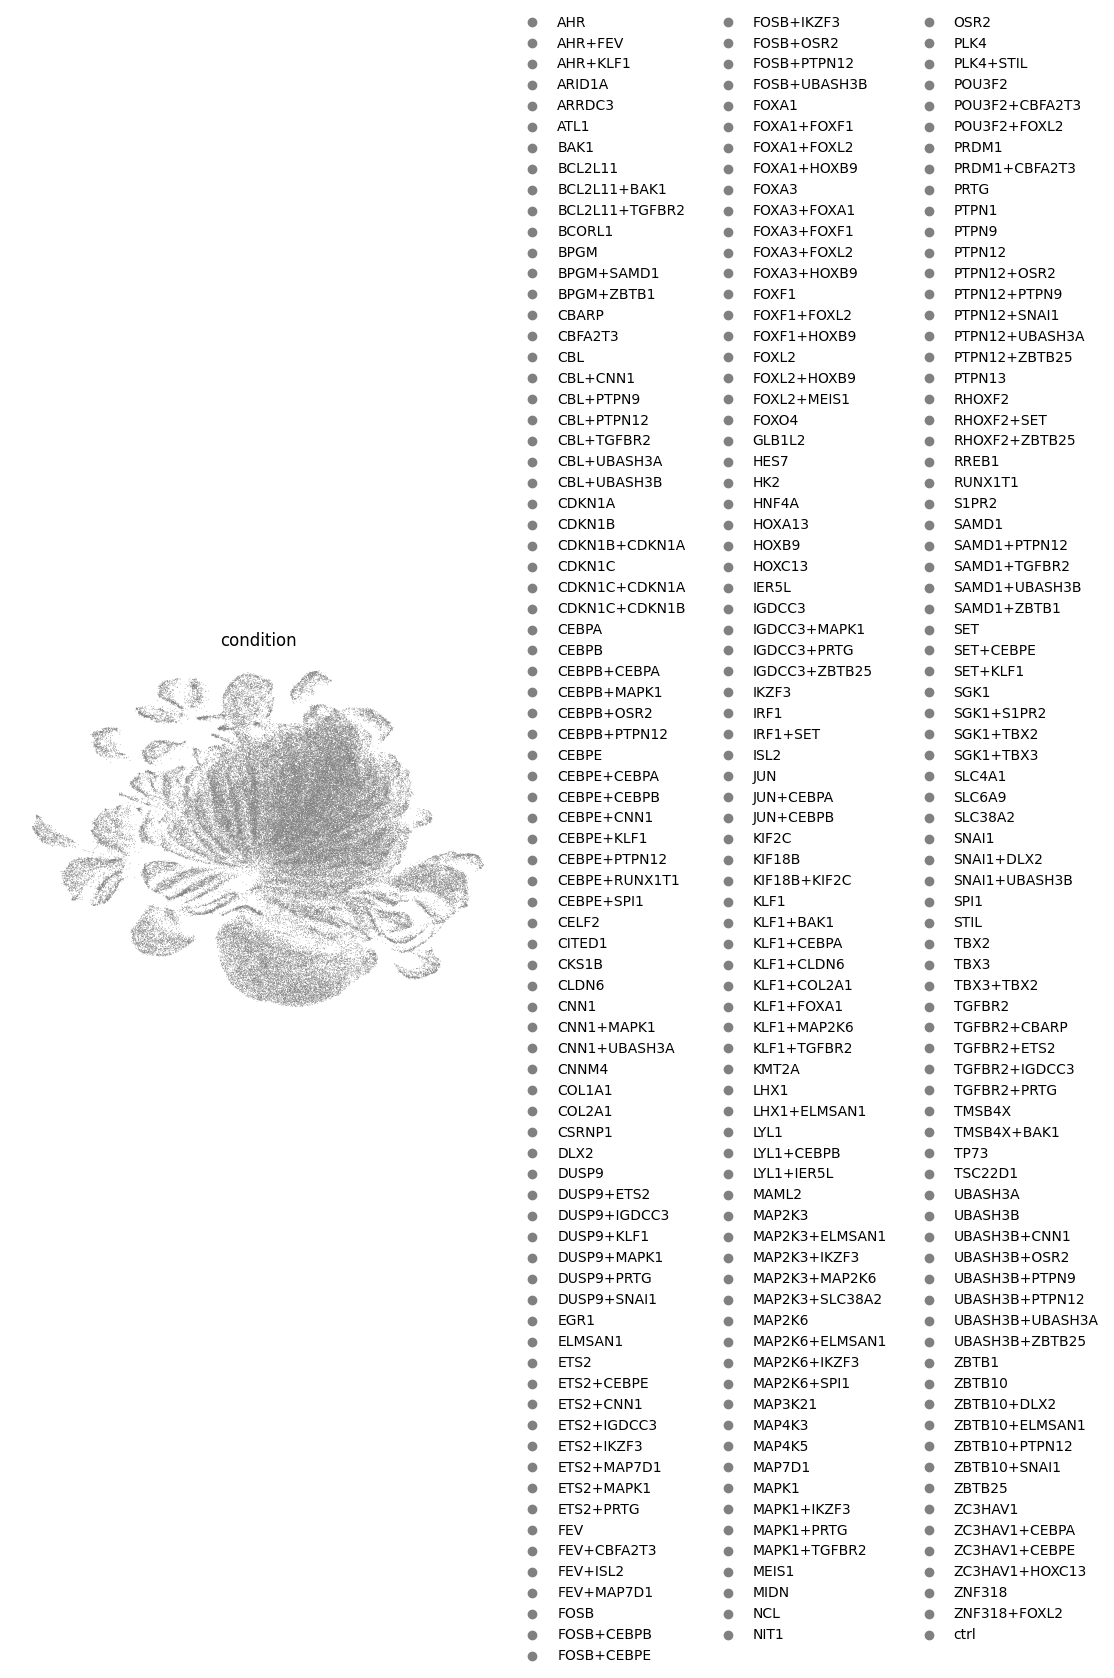

In [21]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )